# Samsung Coding Challenge -- Bertrand Delorme -- 23/05/2018

### *Exploration Notebook*
In this notebook, I justify the choices that I made to solve the coding challenge.

### Steps followed:
1. Data import
2. Data visualization
3. Features engineering
4. Choice of model architecture and parameters optimization

### Important libraries used:
- numpy is used for efficient data structures and functions for scientific computing.
- pandas is used for data manipulation and data analysis.
- matplotlib is used for data visualization.
- scikit-learn is used for efficient implementation of machine learning algorithms.


## Data Import

In [123]:
import pandas as pd

data = pd.read_csv('../data/qualite-de-lair-mesuree-dans-la-station-franklin-d-roosevelt_date_sorted.csv',
                  delimiter=';')

print('{} instances for {} features.'.format(data.shape[0], data.shape[1]))

35039 instances for 7 features.


In [124]:
data.sample(5)

,date/heure,NO,NO2,PM10,CO2,TEMP,HUMI
17603,2015-01-04T14:00:00+01:00,34.0,79.0,29.0,470.0,13.8,34.2
16079,2014-11-02T02:00:00+01:00,NaN,NaN,79.0,NaN,12.3,51.2
13783,2014-07-29T11:00:00+02:00,47.0,60.0,43.0,399.0,24.1,51.5
30527,2016-06-26T03:00:00+02:00,27.0,54.0,26.0,419.0,22.0,48.2
8465,2013-12-19T19:00:00+01:00,129.0,104.0,57.0,673.0,14.4,53.3


#### *Change date format and set as index (easier to handle)*

In [125]:
data['date/heure'] = pd.to_datetime(data['date/heure'])
data.set_index('date/heure', inplace=True)
data.sample(5)

,NO,NO2,PM10,CO2,TEMP,HUMI
date/heure,,,,,,
2014-12-15 00:00:00,46.0,56.0,24.0,430.0,9.3,55.1
2016-05-18 23:00:00,14.0,48.0,18.0,447.0,17.4,57.2
2014-11-06 02:00:00,5.0,21.0,46.0,NaN,23.0,60.3
2013-02-23 09:00:00,15.0,48.0,41.0,NaN,9.6,43.9
2016-02-16 12:00:00,31.0,62.0,20.0,502.0,11.5,37.4


## Data Visualization

### Global metrics for each feature

In [126]:
from collections import OrderedDict
od = OrderedDict([('Type', data.dtypes.values), ('#NaN', data.isnull().sum().values), 
                  ('Min', data.min()), ('Max', data.max()), ('Mean', data.mean()), 
                  ('Median', data.median())])
df = pd.DataFrame(data = od, index = data.dtypes.index)
display(df)

,Type,#NaN,Min,Max,Mean,Median
NO,float64,3690,2.0,929.0,46.537178,33.0
NO2,float64,3356,5.0,242.0,62.358552,62.0
PM10,float64,1691,5.0,979.0,41.227240,33.0
CO2,float64,3188,390.0,1056.0,479.098929,471.0
TEMP,float64,1293,5.7,33.1,18.457065,18.2
HUMI,float64,1302,19.6,95.4,49.707772,49.6


$\rightarrow$ no unrealistic values but presence of gaps, particularly for NO, NO2 and CO2.

### Time series

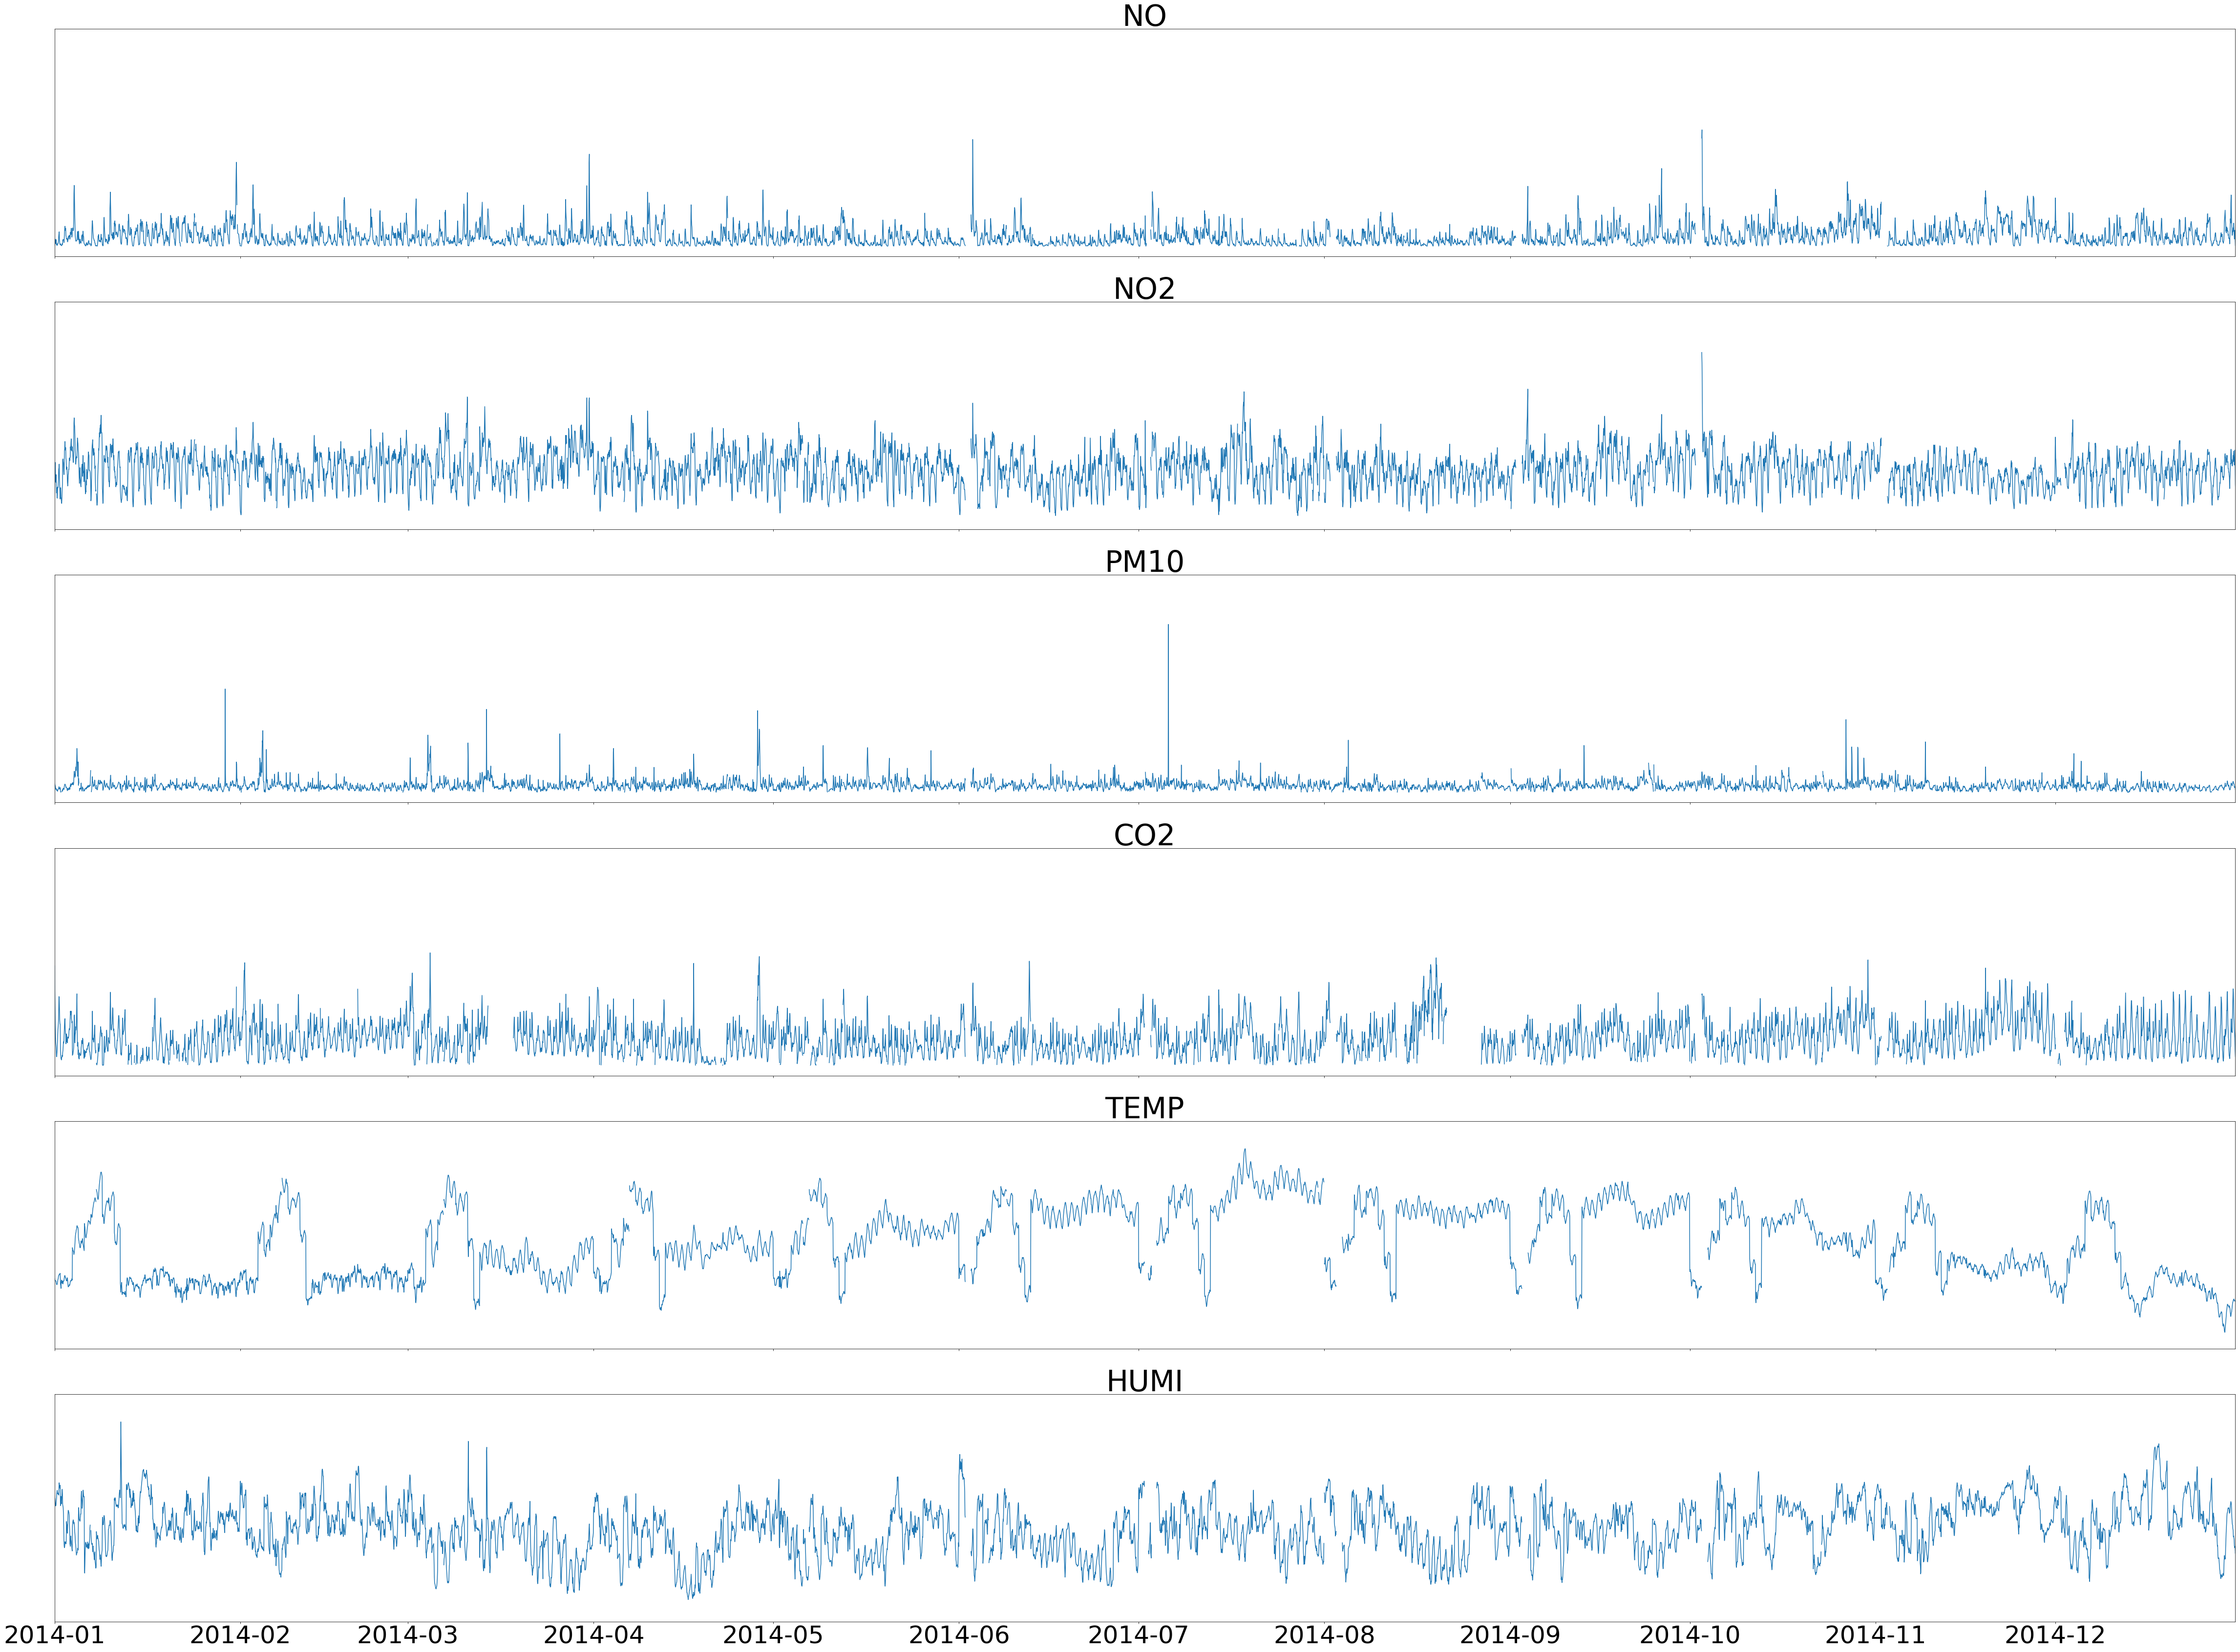

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as dt

# Change date range for zooming/dezooming in the time series here:
date_lim_inf = dt.date(2014, 1, 1)
date_lim_sup = dt.date(2014, 12, 31)

f, axarr = plt.subplots(len(data.columns), sharex=True, figsize=(80, 60))
for i in range(len(data.columns)):
    axarr[i].plot(data.index, data[data.columns[i]])
    axarr[i].set_title(data.columns[i], fontsize=60)
    axarr[i].xaxis.set_tick_params(labelsize=50)
    axarr[i].set_yticks([])
    axarr[i].set_xlim([date_lim_inf, date_lim_sup])

The time series look rather noisy at first glance. TEMP has an annual cycle with hotter values on average in the summer and colder values in the winter. However, heating occurs at the beginning of each month followed by an opposite cooling event. This behavior occurs over the course of 2 weeks or so. This observation suggests that 'day of the month' is an important feature. We observe also a diurnal cycle, suggesting that 'hour of the day' is also an important feature. From these time series, it doesn't seem that the chemical tracers and humidity have a strong influence on the temperature.

### Correlation between features

In [6]:
data.corr()

,NO,NO2,PM10,CO2,TEMP,HUMI
NO,1.000000,0.513895,0.326259,0.504125,-0.241274,0.170002
NO2,0.513895,1.000000,0.194424,0.432237,0.079191,-0.193386
PM10,0.326259,0.194424,1.000000,0.505803,0.064914,-0.090951
CO2,0.504125,0.432237,0.505803,1.000000,-0.102007,-0.048290
TEMP,-0.241274,0.079191,0.064914,-0.102007,1.000000,-0.243077
HUMI,0.170002,-0.193386,-0.090951,-0.048290,-0.243077,1.000000


This table confirms our previous observation: the chemical tracers and humidity doesn't affect significantly the temperature.

### Autocorrelation of Temperature

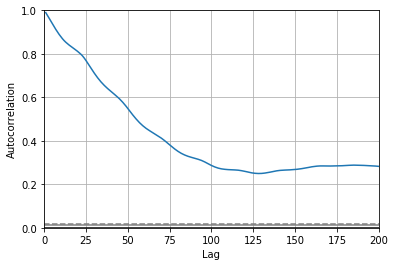

In [7]:
from pandas.plotting import autocorrelation_plot

data_no_nan = data.dropna()
autocorrelation_plot(data_no_nan['TEMP'])
plt.xlim([0,200])
plt.ylim([0,1])
plt.show()

High (>0.8) autocorrelation up to a lag of one day and very high autocorrelation for lags of a few hours.

## Features Engineering
Based on the previous observations, we add 2 new temporal features.

In [127]:
data['hour_of_day'] = data.index.hour
data['day_of_month'] = data.index.day

We drop the features with low impact and high number of NaN.

In [128]:
data.drop(['NO','NO2','CO2','PM10', 'HUMI'], axis=1, inplace = True)

We add the temperature at t+1 to be predicted.

In [129]:
data['TEMP+1'] = data['TEMP'].shift(-1)

To account for the autocorrelation of the data, we add the temperature at t-1.

In [130]:
data['TEMP-1'] = data['TEMP'].shift(1)

We drop instances with NaN.

In [131]:
data.dropna(inplace = True)

Our processed dataset looks like that.

In [132]:
data.sample(5)

,TEMP,day_of_month,TEMP+1,TEMP-1
date/heure,,,,
2016-12-01 20:00:00,13.4,1,13.3,13.5
2015-06-30 08:00:00,25.2,30,25.7,24.3
2014-01-09 00:00:00,21.8,9,21.8,27.1
2016-04-19 09:00:00,16.0,19,16.6,15.3
2014-01-23 01:00:00,10.8,23,13.2,11.8


## Model Architecture: Random Forest

#### Split data between label and features

In [133]:
y = data['TEMP+1']
X = data.drop('TEMP+1', axis=1)

#### Grid Search and Cross-Validation

In [134]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

'''
param_search = {'n_estimators' : [10, 100, 250, 500], 'max_depth' : [5, 10, 25, 50, None]}
my_cv = TimeSeriesSplit(n_splits=10).split(X)
gsearch = GridSearchCV(estimator=RandomForestRegressor(), cv=my_cv, param_grid=param_search, scoring='r2')
gsearch.fit(X, y)
print('Grid best parameter (max. r2): ', gsearch.best_params_)
print('Grid best score (r2): ', gsearch.best_score_)
'''



"\nparam_search = {'n_estimators' : [10, 100, 250, 500], 'max_depth' : [5, 10, 25, 50, None]}\nmy_cv = TimeSeriesSplit(n_splits=10).split(X)\ngsearch = GridSearchCV(estimator=RandomForestRegressor(), cv=my_cv, param_grid=param_search, scoring='r2')\ngsearch.fit(X, y)\nprint('Grid best parameter (max. r2): ', gsearch.best_params_)\nprint('Grid best score (r2): ', gsearch.best_score_)\n"

#### Prediction example

In [135]:
# separate dataset into train and test
Nlim = int(len(y)*0.8)
X_train = X.iloc[:Nlim]
X_test = X.iloc[Nlim:]
y_train = y.iloc[:Nlim]
y_test = y.iloc[Nlim:]

regressor = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=0).fit(X_train, y_train)
print('Train score: {}'.format(regressor.score(X_train, y_train)))
print('Test score: {}'.format(regressor.score(X_test, y_test)))

y_pred_test = regressor.predict(X_test)
y_pred_train = regressor.predict(X_train)

# Plot
date_lim_inf = dt.date(2016, 4, 1)
date_lim_sup = dt.date(2016, 4, 21)

plt.figure(figsize=(10, 3))
plt.plot(y_train.index, y_train, label="train")
plt.plot(y_test.index, y_test, label="test")
plt.plot(y_train.index, y_pred_train, '--', label="prediction train")
plt.plot(y_test.index, y_pred_test, '--', label="prediction test")
plt.legend(loc=(1.01, 0))
plt.xlabel("Date")
plt.ylabel("Temp")
plt.xlim([date_lim_inf, date_lim_sup])

Train score: 0.9894125764582906
Test score: 0.9772649163792807


NameError: name 'dt' is not defined

RNN

In [ ]:

def Emojify_V2(input_shape, word_to_vec_map, word_to_index):
    """
    Function creating the Emojify-v2 model's graph.
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """
    
    ### START CODE HERE ###
    
    # Define sentence_indices as the input of the graph, it should be of shape input_shape and dtype 'int32' (as it contains indices).
    inputs = Input(shape=input_shape, dtype='float64')
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # Be careful, the returned output should be a batch of sequences.
    X = LSTM(128, return_sequences=True)(inputs)
    
    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X)
    
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # Be careful, the returned output should be a single hidden state, not a batch of sequences.
    X = LSTM(128)(X)
    
    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X)
    
    # Propagate X through a Dense layer with softmax activation to get back a batch of 5-dimensional vectors.
    X = Dense(5, activation='softmax')(X)
    
    # Add a softmax activation
    X = Activation('softmax')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=sentence_indices, outputs=X)
    
    ### END CODE HERE ###
    
    return model